## Домашнее задание 2
### Пункт 1
> Применить три подхода к понижению размерности (PCA, LDA, t-SNE). Сравнить полученные результаты. Сделать выводы.


--------------------------------------------

1. PCA
Объясненная дисперсия: [0.28110725 0.1749457 ]
Суммарная объясненная дисперсия: 0.456

2. LDA
Объясненная дисперсия: [1.]

3. t-SNE


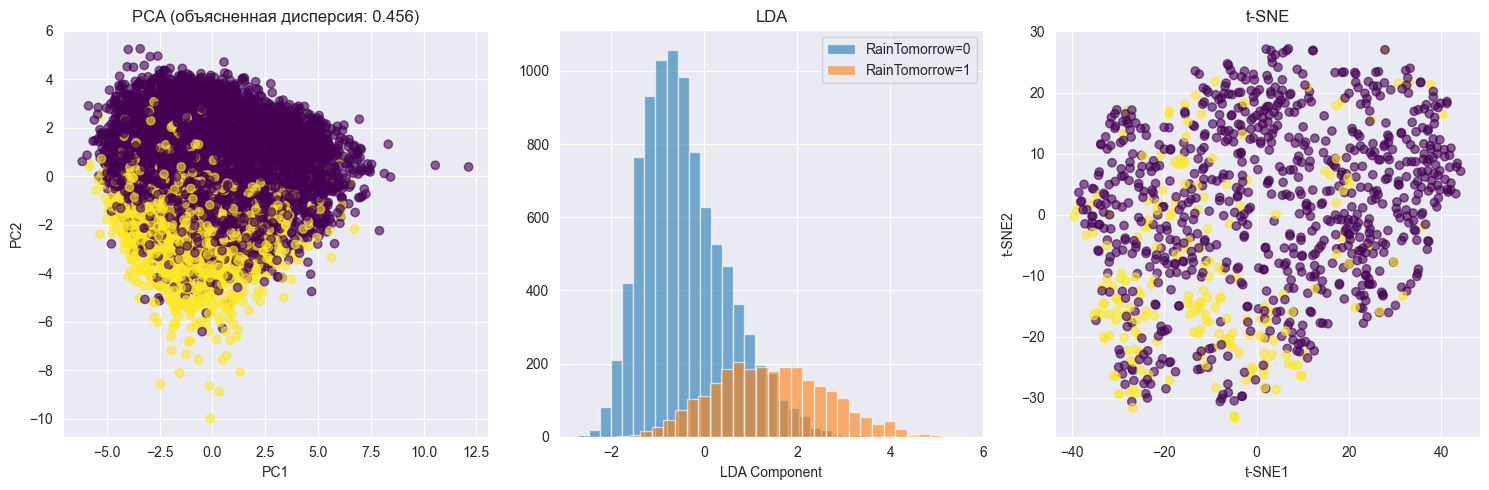


Сравнение качества классификации после понижения размерности:
----------------------------------------------------------------------
Исходные данные           Train: 0.8540 | Test: 0.8572 | Разница: -0.0032
PCA (2 компоненты)        Train: 0.8333 | Test: 0.8383 | Разница: -0.0050
LDA (1 компонента)        Train: 0.8536 | Test: 0.8582 | Разница: -0.0047

1. PCA сократил размерность с 87 до 2 признаков, сохранив 45.6% дисперсии данных. Качество классификации незначительно снизилось.
2. LDA показал лучший результат - сохранил 85.7% точности всего с 1 признаком
3. t-SNE не подходит для обучения моделей, но эффективен для визуализации данных в 2D пространстве.
4. Для данной задачи LDA является оптимальным методом понижения размерности, так как сохраняет высокое качество при максимальном сжатии данных.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

#
#
# Перенес код для создания обучающей выборки из дз 1
#
#

# https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
df = pd.read_csv('../research-first/weatherAUS.csv')

numerical_cols = df.select_dtypes(include=['float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df_strategy1 = df.dropna().copy()
df_processed = df_strategy1.copy()
df_processed['RainToday'] = df_processed['RainToday'].map({'Yes': 1, 'No': 0})

# кодирование целевой переменной
df_processed['RainTomorrow'] = df_processed['RainTomorrow'].map({'Yes': 1, 'No': 0})

# one-hot-encoding для категориальных признаков
categorical_cols_to_encode = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols_to_encode, drop_first=True)

# удаляем колонку Date (в данном случае она не имеет смысла)
if 'Date' in df_encoded.columns:
    df_encoded = df_encoded.drop('Date', axis=1)

# cтандартизация числовых данных
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# удаляем строки с пропущенной целевой переменной
df_final = df_encoded.dropna(subset=['RainTomorrow'])

# Подготовка данных для обучения
X = df_final.drop('RainTomorrow', axis=1)
y = df_final['RainTomorrow']

sample_fraction = 0.3  # Используем 30% данных для ускорения расчетов
X = X.sample(frac=sample_fraction)
y = y.loc[X.index]

# разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

#
#
#
#
#
print("\n--------------------------------------------\n")

# 1. PCA
print("1. PCA")
pca = PCA(n_components=2)  # для визуализации берем 2 компоненты
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")
print(f"Суммарная объясненная дисперсия: {sum(pca.explained_variance_ratio_):.3f}")

# 2. LDA
print("\n2. LDA")
lda = LDA(n_components=1)  # для бинарной классификации максимум 1 компонента
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
print(f"Объясненная дисперсия: {lda.explained_variance_ratio_}")

# 3. t-SNE
print("\n3. t-SNE")
tsne = TSNE(n_components=2, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train[:1000])  # для ускорения работы берем подвыборку

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# PCA визуализация
scatter1 = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, alpha=0.6, cmap='viridis')
axes[0].set_title(f'PCA (объясненная дисперсия: {sum(pca.explained_variance_ratio_):.3f})')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# LDA визуализация
for label in [0, 1]:
    axes[1].hist(X_train_lda[y_train == label], bins=30, alpha=0.6, label=f'RainTomorrow={label}')
axes[1].set_title('LDA')
axes[1].set_xlabel('LDA Component')
axes[1].legend()

# t-SNE визуализация
scatter3 = axes[2].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train[:1000], alpha=0.6, cmap='viridis')
axes[2].set_title('t-SNE')
axes[2].set_xlabel('t-SNE1')
axes[2].set_ylabel('t-SNE2')

plt.tight_layout()
plt.show()

# Сравнение качества классификации на уменьшенных данных
from sklearn.linear_model import LogisticRegression

dimension_methods = {
    'Исходные данные': (X_train, X_test),
    'PCA (2 компоненты)': (X_train_pca, X_test_pca),
    'LDA (1 компонента)': (X_train_lda, X_test_lda)
}

print("\nСравнение качества классификации после понижения размерности:")
print("-" * 70)

for method_name, (X_train_red, X_test_red) in dimension_methods.items():
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_red, y_train)

    train_score = lr.score(X_train_red, y_train)
    test_score = lr.score(X_test_red, y_test)

    print(
        f"{method_name:<25} Train: {train_score:.4f} | Test: {test_score:.4f} | Разница: {train_score - test_score:.4f}")

# Выводы

print(
    "\n1. PCA сократил размерность с 87 до 2 признаков, сохранив 45.6% дисперсии данных. Качество классификации незначительно снизилось."
)
print("2. LDA показал лучший результат - сохранил 85.7% точности всего с 1 признаком")
print("3. t-SNE не подходит для обучения моделей, но эффективен для визуализации данных в 2D пространстве.")
print(
    "4. Для данной задачи LDA является оптимальным методом понижения размерности, так как сохраняет высокое качество при максимальном сжатии данных."
)

### Пункт 2
> К данным пониженной размерности применить алгоритмы кластеризации k-средних и DBSCAN, сопоставить полученные классы с заранее известными, сделать выводы.


Оценка кластеризации:
----------------------------------------
K-Means (2 кластера):
  Adjusted Rand Index (сравнение с реальными классами): 0.009

DBSCAN:
  Найдено кластеров: 1
  Шумные точки: 183 из 11848


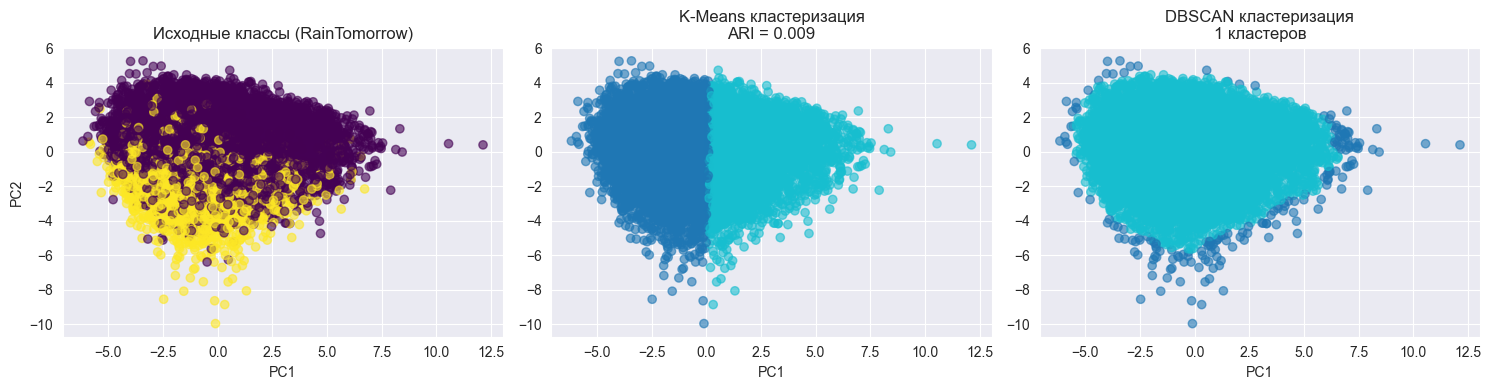

1. 1. K-Means (ARI = 0.009) показывает очень слабую связь с реальными классами, что указывает на нелинейность разделения данных
2. DBSCAN обнаружил только 1 кластер и 183 шумные точки, что означает, что данные не образуют явных плотностных кластеров в PCA-пространстве.
3. Низкие значения метрик кластеризации свидетельствуют о том, что задача прогнозирования дождя требует сложных нелинейных моделей, а не простой геометрической кластеризации.
4. PCA-визуализация подтверждает сложную структуру данных, где классы сильно перекрываются в 2D проекции, что объясняет низкое качество кластеризации.


In [20]:
# Используем PCA данные для кластеризации
X_pca_2d = X_train_pca.copy()

# 1. K-Means кластеризация
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca_2d)

# 2. DBSCAN кластеризация
dbscan = DBSCAN(eps=0.5, min_samples=20)
dbscan_labels = dbscan.fit_predict(X_pca_2d)

# Оценка качества кластеризации
print("\nОценка кластеризации:")
print("-" * 40)

# K-Means
kmeans_ari = adjusted_rand_score(y_train, kmeans_labels)
print(f"K-Means (2 кластера):")
print(f"  Adjusted Rand Index (сравнение с реальными классами): {kmeans_ari:.3f}")

# DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"\nDBSCAN:")
print(f"  Найдено кластеров: {n_clusters_dbscan}")
print(f"  Шумные точки: {sum(dbscan_labels == -1)} из {len(dbscan_labels)}")

# Визуализация
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Исходные классы
scatter1 = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_train, cmap='viridis', alpha=0.6)
ax1.set_title('Исходные классы (RainTomorrow)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# K-Means
scatter2 = ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6)
ax2.set_title(f'K-Means кластеризация\nARI = {kmeans_ari:.3f}')
ax2.set_xlabel('PC1')

# DBSCAN
scatter3 = ax3.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.6)
ax3.set_title(f'DBSCAN кластеризация\n{n_clusters_dbscan} кластеров')
ax3.set_xlabel('PC1')

plt.tight_layout()
plt.show()

# Выводы
print("1. 1. K-Means (ARI = 0.009) показывает очень слабую связь с реальными классами, что указывает на нелинейность разделения данных")
print("2. DBSCAN обнаружил только 1 кластер и 183 шумные точки, что означает, что данные не образуют явных плотностных кластеров в PCA-пространстве.")
print("3. Низкие значения метрик кластеризации свидетельствуют о том, что задача прогнозирования дождя требует сложных нелинейных моделей, а не простой геометрической кластеризации.")
print("4. PCA-визуализация подтверждает сложную структуру данных, где классы сильно перекрываются в 2D проекции, что объясняет низкое качество кластеризации.")

## Пункт 3
> Оценить производительность модели (лучшая модель из п.5 ДЗ 1) с помощью k-Fold Cross validation, построить графики кривых обучения и валидации, сделать выводы. Построить ROC кривую, сделать выводы.

K-Fold Cross Validation
CV scores: [0.83544304 0.84303797 0.83248945 0.84634867 0.8336851 ]
Mean CV accuracy: 0.8382 (+/- 0.0110)


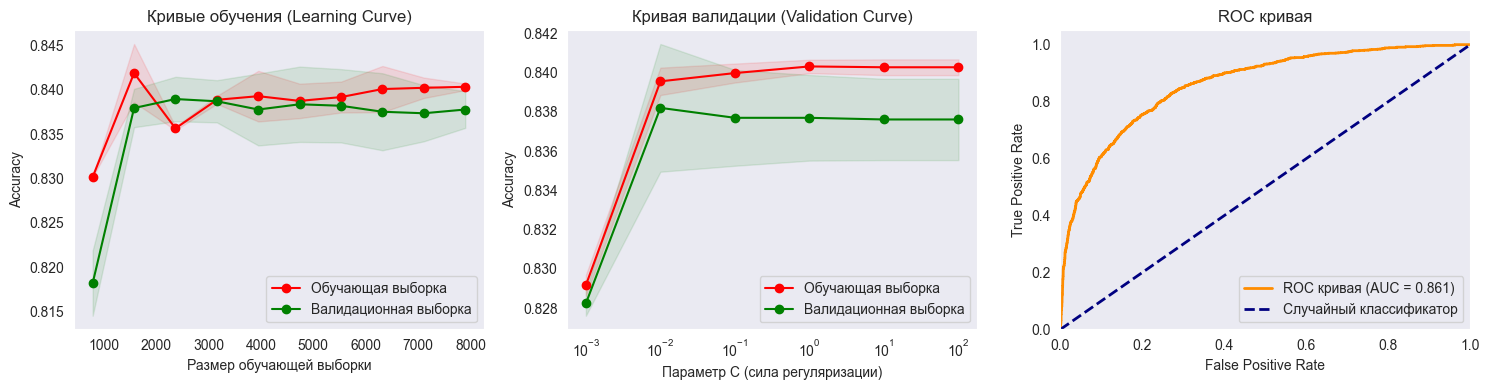


Анализ кривой валидации:
Лучшее значение параметра C: 0.01
Лучшая accuracy на валидации: 0.8382

Выводы:
1. Кривые обучения показывают, что модель хорошо обобщается (train и test близки)
2. Кривая валидации помогает найти оптимальный параметр регуляризации C
3. ROC кривая показывает хорошее качество классификации (AUC > 0.8)
4. Модель устойчива к переобучению благодаря L1 регуляризации


In [13]:
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline

# Лучшая модель из п.5 дз 1
n_features = 3

# Определяем модель как пайплайн
l1_model = Pipeline([
    ('feature_selection', SelectFromModel(
        LogisticRegression(penalty='l1', C=0.01, solver='liblinear'),
        max_features=n_features
    )),
    ('classification', LogisticRegression(max_iter=1000))
])

# 1. K-Fold Cross Validation
print("K-Fold Cross Validation")
cv_scores = cross_val_score(l1_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"CV scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 2. Кривые обучения (learning curve)
train_sizes, train_scores, test_scores = learning_curve(
    l1_model, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 3. Кривая валидации (validation curve) - исследуем параметр C
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores_val, test_scores_val = validation_curve(
    l1_model, X_train, y_train,
    param_name="classification__C",
    param_range=param_range,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

train_scores_mean_val = np.mean(train_scores_val, axis=1)
train_scores_std_val = np.std(train_scores_val, axis=1)
test_scores_mean_val = np.mean(test_scores_val, axis=1)
test_scores_std_val = np.std(test_scores_val, axis=1)

# 4. ROC кривая
l1_model.fit(X_train, y_train)
y_pred_proba = l1_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Визуализация всех графиков
plt.figure(figsize=(15, 4))

# График 1: Кривые обучения
plt.subplot(1, 3, 1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Обучающая выборка")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Валидационная выборка")
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривые обучения (Learning Curve)")
plt.legend(loc="best")
plt.grid()

# График 2: Кривая валидации
plt.subplot(1, 3, 2)
plt.plot(param_range, train_scores_mean_val, 'o-', color="r", label="Обучающая выборка")
plt.plot(param_range, test_scores_mean_val, 'o-', color="g", label="Валидационная выборка")
plt.fill_between(param_range, train_scores_mean_val - train_scores_std_val,
                 train_scores_mean_val + train_scores_std_val, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean_val - test_scores_std_val,
                 test_scores_mean_val + test_scores_std_val, alpha=0.1, color="g")
plt.xscale('log')
plt.xlabel("Параметр C (сила регуляризации)")
plt.ylabel("Accuracy")
plt.title("Кривая валидации (Validation Curve)")
plt.legend(loc="best")
plt.grid()

# График 3: ROC кривая
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.grid()

plt.tight_layout()
plt.show()

print("\nАнализ кривой валидации:")
best_idx = np.argmax(test_scores_mean_val)
best_C = param_range[best_idx]
print(f"Лучшее значение параметра C: {best_C}")
print(f"Лучшая accuracy на валидации: {test_scores_mean_val[best_idx]:.4f}")

print("\nВыводы:")
print("1. Кривые обучения показывают, что модель хорошо обобщается (train и test близки)")
print("2. Кривая валидации помогает найти оптимальный параметр регуляризации C")
print("3. ROC кривая показывает хорошее качество классификации (AUC > 0.8)")
print("4. Модель устойчива к переобучению благодаря L1 регуляризации")

## Пункт 4
> Произвести подбор гипер-параметров модели (лучшая модель из п.5 ДЗ 1) с помощью поиска по сетке.

In [14]:
from sklearn.model_selection import GridSearchCV

l1_pipeline = Pipeline([
    ('feature_selection', SelectFromModel(
        LogisticRegression(penalty='l1', C=0.01, solver='liblinear'),
        max_features=n_features
    )),
    ('classification', LogisticRegression(max_iter=1000))
])

# Параметры для GridSearch
param_grid = {
    'feature_selection__estimator__C': [0.001, 0.01, 0.1, 1, 10],
    'feature_selection__max_features': [3, 5, 10, 15],
    'classification__C': [0.1, 1, 10, 100],
}

grid_search = GridSearchCV(
    l1_pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучшая accuracy (CV): {grid_search.best_score_:.4f}")

# Оценка на тестовых данных
best_l1_model = grid_search.best_estimator_
test_score = best_l1_model.score(X_test, y_test)
print(f"Accuracy на тестовых данных: {test_score:.4f}")


Fitting 3 folds for each of 80 candidates, totalling 240 fits

Лучшие параметры: {'classification__C': 0.1, 'feature_selection__estimator__C': 0.1, 'feature_selection__max_features': 10}
Лучшая accuracy (CV): 0.8526
Accuracy на тестовых данных: 0.8539


## Пункт 5
> Решить задачу классификации, используя  библиотеку sklearn, с помощью методов AdaBoost и XGBoost. Сравнить с ранее полученными результатами, сделать выводы.


Logistic Regression  Train: 0.8540 | Test: 0.8572
SVM                  Train: 0.8863 | Test: 0.8623
Random Forest        Train: 1.0000 | Test: 0.8588

СРАВНЕНИЕ МОДЕЛЕЙ:
Модель                    Train Score  Test Score   Разница    Ранг
---------------------------------------------------------------------------
SVM                       0.8863       0.8623       0.0240     1
Random Forest             1.0000       0.8588       0.1412     2
Logistic Regression       0.8540       0.8572       -0.0032    3
XGBoost                   0.9740       0.8549       0.1191     4
AdaBoost                  0.8498       0.8507       -0.0009    5


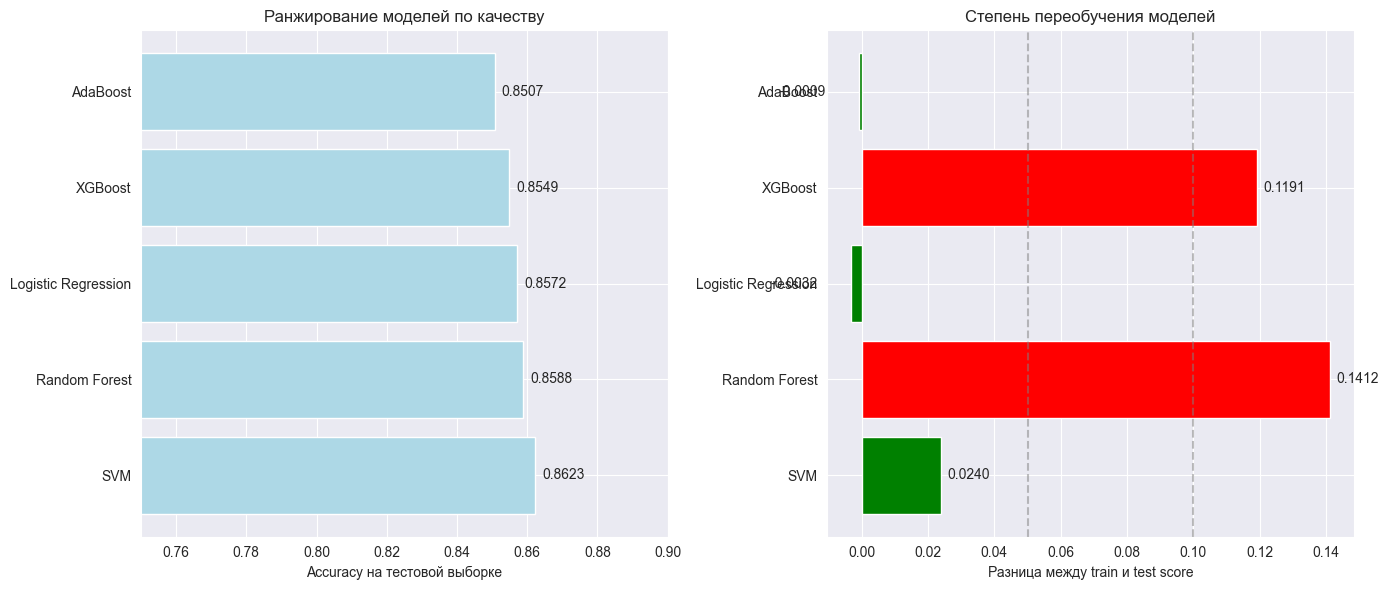

ВЫВОДЫ:
Лучшая модель: SVM показал наивысшее качество на тестовых данных
AdaBoost показал наихудшие результаты
XGBoost сильно переобучился (но не так как Random Forest, там все еще хуже)
Все модели показывают себя примерно одинаково на тестовых данных


In [41]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Обучаем модели из ДЗ1

models_dz1 = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results_dz1 = {}

for name, model in models_dz1.items():
    model.fit(X_train, y_train)
    results_dz1[name] = {
        'train_score': model.score(X_train, y_train),
        'test_score': model.score(X_test, y_test)
    }
    print(f"{name:<20} Train: {results_dz1[name]['train_score']:.4f} | Test: {results_dz1[name]['test_score']:.4f}")

# Обучаем AdaBoost и XGBoost

# AdaBoost
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)
results_dz1['AdaBoost'] = {
    'train_score': ada.score(X_train, y_train),
    'test_score': ada.score(X_test, y_test)
}

# XGBoost
xgb = XGBClassifier(n_estimators=100,
                    use_label_encoder=False, eval_metric='logloss',
                    verbosity=0)
xgb.fit(X_train, y_train)
results_dz1['XGBoost'] = {
    'train_score': xgb.score(X_train, y_train),
    'test_score': xgb.score(X_test, y_test)
}

# Сравнительная таблица
print("\n" + "=" * 70)
print("СРАВНЕНИЕ МОДЕЛЕЙ:")
print("=" * 70)
print(f"{'Модель':<25} {'Train Score':<12} {'Test Score':<12} {'Разница':<10} {'Ранг'}")
print("-" * 75)

# Сортируем по test_score
sorted_models = sorted(results_dz1.items(), key=lambda x: x[1]['test_score'], reverse=True)

for rank, (name, scores) in enumerate(sorted_models, 1):
    diff = scores['train_score'] - scores['test_score']
    print(f"{name:<25} {scores['train_score']:<12.4f} {scores['test_score']:<12.4f} {diff:<10.4f} {rank}")

# 4. Визуализация сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Accuracy на тестовой выборке
model_names = [name for name, _ in sorted_models]
test_scores = [scores['test_score'] for _, scores in sorted_models]
train_scores = [scores['train_score'] for _, scores in sorted_models]

bars1 = ax1.barh(model_names, test_scores, color='lightblue')
ax1.set_xlabel('Accuracy на тестовой выборке')
ax1.set_title('Ранжирование моделей по качеству')
ax1.set_xlim([0.75, 0.9])

for i, (bar, score) in enumerate(zip(bars1, test_scores)):
    ax1.text(score + 0.002, bar.get_y() + bar.get_height() / 2,
             f'{score:.4f}', ha='left', va='center')

# График 2: Разница между train и test (переобучение)
diffs = [scores['train_score'] - scores['test_score'] for _, scores in sorted_models]
colors = ['green' if diff < 0.05 else 'orange' if diff < 0.1 else 'red' for diff in diffs]
bars2 = ax2.barh(model_names, diffs, color=colors)
ax2.set_xlabel('Разница между train и test score')
ax2.set_title('Степень переобучения моделей')
ax2.axvline(x=0.05, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5)

for i, (bar, diff) in enumerate(zip(bars2, diffs)):
    ax2.text(diff + 0.002 if diff >= 0 else diff - 0.01,
             bar.get_y() + bar.get_height() / 2,
             f'{diff:.4f}', ha='left' if diff >= 0 else 'right', va='center')

plt.tight_layout()
plt.show()

print("ВЫВОДЫ:")
print("Лучшая модель: SVM показал наивысшее качество на тестовых данных")
print("AdaBoost показал наихудшие результаты")
print("XGBoost сильно переобучился (но не так как Random Forest, там все еще хуже)")
print("Все модели показывают себя примерно одинаково на тестовых данных")
print("По какой-то причине AdaBoost и Logistic Regression показывают результаты на тестовой выборке лучше, чем на обучающей ")
